In [1]:
# === USEFUL PACKAGES ===
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eig, eigh
from scipy.special import yv, jv, jvp, kv, kvp
from scipy.optimize import root_scalar
from scipy.interpolate import griddata
import scipy.sparse as sp
from scipy.sparse.linalg import eigs
from petsc4py import PETSc
from slepc4py import SLEPc

In [58]:
# ---------------------------------------------------------------
#  Solveur SLEPc pour A u = ω B u, avec shift-invert sur ω_target
# ---------------------------------------------------------------
def solve_evp_slepc(A, B, omega_target, nev=10, tol=1e-10, max_it=1000):

    n = A.shape[0]
    assert A.shape == B.shape == (n, n)

    # matrices PETSc
    A_p = PETSc.Mat().createDense(A.shape)
    B_p = PETSc.Mat().createDense(B.shape)

    A_p.setValues(range(n), range(n), A)
    B_p.setValues(range(n), range(n), B)
    A_p.assemble()
    B_p.assemble()

    E = SLEPc.EPS().create()
    E.setOperators(A_p, B_p)

    # Problème généralisé
    E.setProblemType(SLEPc.EPS.ProblemType.GNHEP)

    # On demande les nev valeurs propres les plus proches du shift
    E.setDimensions(nev, PETSc.DECIDE)

    # Shift-invert ciblé
    E.setTarget(omega_target)
    E.setWhichEigenpairs(SLEPc.EPS.Which.TARGET_MAGNITUDE)

    # Active le spectre transformé
    ST = E.getST()
    ST.setType(SLEPc.ST.Type.SINVERT)

    # Configuration numérique
    E.setTolerances(tol, max_it)
    E.setFromOptions()

    E.solve()

    nconv = E.getConverged()
    if nconv == 0:
        raise RuntimeError("Aucune valeur propre n'a convergé.")

    # Extraction des valeurs et vecteurs propres
    omegas = []
    vecs   = []

    xr = PETSc.Vec().createSeq(n)
    xi = PETSc.Vec().createSeq(n)

    # Récupération des modes
    for i in range(nconv):
        lam = E.getEigenvalue(i)
        E.getEigenvector(i, xr, xi)

        # xr = partie réelle, xi = partie imaginaire
        if np.iscomplexobj(PETSc.ScalarType()):
            u = xr.getArray().copy()
        else:
            u = xr.getArray() + 1j * xi.getArray()

        omegas.append(lam)
        vecs.append(u)

    omegas = np.array(omegas, dtype=complex)
    vecs   = np.column_stack(vecs)

    # Sélection du mode proche du shift ω_target
    idx = np.argmin(np.abs(omegas - omega_target))
    omega_dom = omegas[idx]
    u_dom     = vecs[:, idx].copy()

    # Normalisation simple
    u_dom /= np.max(np.abs(u_dom))

    return omega_dom, u_dom


ω_MC idéal : 3.807368106876057
ω_NUM    : (3.8073448114730155-4.0446754320105766e-05j)
Résidu : 1.1094835199205168e-10


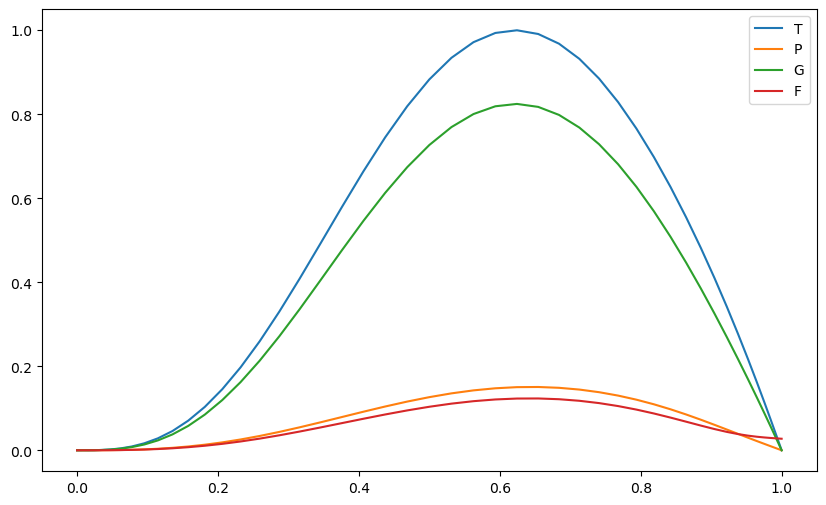

In [84]:
# === PHYSICAL PARAMETERS ===
h, a = 1, 1
m, n_axial = 2,1
k = (n_axial * np.pi) / h

B0, Omega_rot, Omega_mass = 1, 1, 1

rho, mu0 = 1, 1
mu, eta = 0.01,0.01
nu = mu/rho

#E = nu/(Omega_rot*h**2)
#Pm = nu/eta
#print('Pm = ', Pm)

N = 50

# === BOUNDARY CONDITIONS ===
def compute_F1_dF1_G1(m, k, a=1.0, C=1.0):
    F1 = C * kv(m, k*a)
    dF1 = C * k * kvp(m, k*a)
    G1 = 0
    return F1, dF1, G1
F1_val, dF1_val, G1_val = compute_F1_dF1_G1(m, k, a=1.0, C=1.0)

v = B0 / np.sqrt(mu0 * rho)
omega_alfven = k * v
Le = v/(Omega_rot*h)

# === IDEAL MHD ===
def omega_MC_ideal(m, n, h, a, Omega_rot, Le, k):
    # Greenspan's equation 
    eq = lambda xi: xi * jvp(abs(m), xi, 1) + m * np.sqrt(1 + (xi**2 * h**2)/(n**2 * np.pi**2 * a**2)) * jv(abs(m), xi)
    xi_vals = np.linspace(1e-4, 200, 1000)
    f_vals = [eq(xi) for xi in xi_vals]
    roots = [root_scalar(eq, bracket=[xi_vals[i], xi_vals[i+1]], method='brentq').root
             for i in range(len(xi_vals)-1) if f_vals[i]*f_vals[i+1] < 0]

    if not roots: return np.nan
    xi0 = roots[0]
    omega_I = 2 / np.sqrt(1 + (xi0**2 * h**2)/(n**2 * np.pi**2 * a**2))
    return (Omega_rot * omega_I / 2) * (1 + np.sqrt(1 + (4 * Le**2 * k**2)/(Omega_rot**2 * omega_I**2)))

omega_MC = omega_MC_ideal(m, n_axial, h, a, Omega_rot, Le, k)

# === CHEBYSHEV MATRIX ===
def cheb_diff(N):
    if N == 0:
        return np.array([[0]]), np.array([1])
    x = -np.cos(np.pi * np.arange(N + 1) / N) # points sur [-1, 1] (ordre croissant, d'où le signe -)
    # Chebyshev coefficients 
    c = np.ones(N + 1) ; c[0], c[-1] = 2, 2 ; c *= (-1) ** np.arange(N + 1)
    # Computation of matrix D
    X = np.tile(x, (N + 1, 1)).T ; dX = X - X.T + np.eye(N + 1)
    D = (np.outer(c, 1 / c)) / dX ; D -= np.diag(np.sum(D, axis=1))
    # s on [0, 1]
    s = 0.5 * (x + 1)
    return 2 * D, s

# === DISCRÉTISATION ===
D, s = cheb_diff(N)
D2 = D @ D
D3 = D2 @ D
D4 = D2 @ D2
n_p = N + 1
size = 4 * n_p

# s régularisé pour éviter les divisions par zéro
s_safe = np.copy(s)
s_safe[s_safe == 0] = 1e-8

T_idx = np.arange(0, n_p)
P_idx = np.arange(n_p, 2 * n_p)
G_idx = np.arange(2 * n_p, 3 * n_p)
F_idx = np.arange(3 * n_p, 4 * n_p)

A = np.zeros((size, size), dtype=complex)
B = np.zeros((size, size), dtype=complex)

# === SYSTEM ===
for j, sj in enumerate(s_safe):
    
    """                  VISCOUS MOMENTUM EQUATION                """
    # Equation 1
    row = j     
    coef0_1T = nu * (k**4 * sj**2 + 2 * k**2 * m**2 + k**2 + (m**4 - m**2)/sj**2)
    coef1_1T = nu * (-k**2 * sj + m**2/sj)
    coef2_1T = nu * (-k**2 * sj**2 - m**2)
    A[row, T_idx] += ( coef0_1T * np.eye(n_p)[j] + coef1_1T * D[j] + coef2_1T * D2[j])
    
    coef0_1P = -2j * Omega_rot * (k**3 * sj**2 + k * m**2) + nu * (-4 * k**3 * m - (4/sj**2) * k * m**3 + (4/sj**2) * k * m)
    coef1_1P = -4 * k * m * nu/sj
    coef2_1P = 4 * k * m * nu
    A[row, P_idx] += (coef0_1P * np.eye(n_p)[j] + coef1_1P * D[j] + coef2_1P * D2[j])
    
    A[row, G_idx[j]] = (-1j * B0 /(mu0 * rho) * (k**3 * sj**2 + k * m**2))
    A[row, F_idx[j]] = (-2j * B0 /(mu0 * rho) * (k**2 * m)) #
    
    # ω
    B[row, T_idx[j]] = (1j * (k**2 * sj**2 + m**2) * Omega_mass)
    B[row, P_idx[j]] = (2j * k * m * Omega_mass) #

    # Equation 2
    row = n_p + j
    coef0_2T = 2j * Omega_rot * (k**3 * sj**2 + k * m**2) + nu * (4/sj**2 *(k * m - k * m**3) - 4 * k**3 * m) #
    coef1_2T =  - 4/sj * k * m * nu
    coef2_2T =  4 * k * m * nu
    A[row, T_idx] += (coef0_2T * np.eye(n_p)[j] + coef1_2T * D[j] + coef2_2T * D2[j])
    
    coef0_2P = 4j * Omega_rot * k**2 * m + nu * (k**6 * sj**2 + 3 * k**4 * m**2 + 2 * k**4 + 3/sj**2 * k**2 * m**4 + (m**6 - 10 * m**4 + 9 * m**2)/sj**4 - 3 * k**2/sj**2) 
    coef1_2P = nu * (-2 * k**4 * sj + 4/sj * k**2 * m**2 + (6 * m**4 - 9 * m**2)/sj**3 + 3/sj * k**2)
    coef2_2P = nu * (-2 * k**4 * sj**2 - 4 * k**2 * m**2 - 3 * k**2 - (2 * m**4 - 5 * m**2)/sj**2)
    coef3_2P = nu * (2 * k**2 * sj - 2/sj * m**2)
    coef4_2P = nu * (k**2 * sj**2 + m**2)
    A[row, P_idx] += (coef0_2P * np.eye(n_p)[j] + coef1_2P * D[j] + coef2_2P * D2[j] + coef3_2P * D3[j] + coef4_2P * D4[j])
    
    A[row, G_idx[j]] = (2j * B0 /(mu0 * rho) * k**2 * m)
    
    coef0_2F = 1j * B0 /(mu0 * rho) * (k**5 * sj**2 + k**3 * (2 * m**2 + 1) + k * (m**4 - m**2)/sj**2) #
    coef1_2F = 1j * B0 /(mu0 * rho) * (-k**3 * sj + (k * m**2)/sj) #
    coef2_2F = -1j * B0 /(mu0 * rho) * (k**3 * sj**2 + k * m**2) #
    A[row, F_idx] += (coef0_2F * np.eye(n_p)[j] + coef1_2F * D[j] + coef2_2F * D2[j])

    # ω
    B[row, T_idx[j]] = (-2j * k * m * Omega_mass)
    
    coef0_2BP = 1j * ( -k**4 * sj**2 - (2 * m**2 + 1) * k**2 + (m**2 - m**4)/sj**2) * Omega_mass#
    coef1_2BP = -1j * (m**2/sj - k**2 * sj) * Omega_mass #
    coef2_2BP = 1j * (k**2 * sj**2 + m**2) * Omega_mass #
    B[row, P_idx] += (coef0_2BP * np.eye(n_p)[j] + coef1_2BP * D[j] + coef2_2BP * D2[j])
    
    """                 DIFFUSIVE INDUCTION EQUATION             """

    # Equation 3 
    row = 2 * n_p + j
    A[row, P_idx[j]] = (-1j * B0 * (k**3 * sj**2 + k * m**2))
    A[row, G_idx[j]] = (-2*eta*k*m)
    
    coef0_3F = eta * (k**4 * sj**2 + 2 * k**2 * m**2 + k**2 + (m**4 - m**2)/sj**2)
    coef1_3F = eta * (m**2/sj - k**2 *sj)
    coef2_3F = -eta * (k**2 * sj**2 + m**2)
    A[row, F_idx] += (coef0_3F * np.eye(n_p)[j] + coef1_3F * D[j] + coef2_3F * D2[j])
    
    # ω
    B[row, F_idx[j]] = (1j * (k**2 * sj**2 + m**2))

    # Equation 4 
    row = 3 * n_p + j
    A[row, T_idx[j]] = (1j * B0 * (k**3 * sj**2 + k * m**2))#
    A[row, P_idx[j]] = (2j * B0 * k**2 * m)
    
    coef0_4G = eta * (k**4 * sj**2 + 2 * k**2 * m**2 + k**2 + (m**4 - m**2)/sj**2)
    coef1_4G = eta * (m**2/sj - k**2 *sj)
    coef2_4G = -eta * (k**2 * sj**2 + m**2)
    A[row, G_idx] += (coef0_4G * np.eye(n_p)[j] + coef1_4G * D[j] + coef2_4G * D2[j])
    
    coef0_4F = -4 * eta * (k**3 * m + (k * m**3 - k * m)/sj**2)
    coef1_4F = -4 * eta * k * m * 1/sj
    coef2_4F = 4 * eta * k * m
    A[row, F_idx] += (coef0_4F * np.eye(n_p)[j] + coef1_4F * D[j] + coef2_4F * D2[j])
    
    # ω
    B[row, G_idx[j]] = (-1j * (k**2 * sj**2 + m**2)) #
    B[row, F_idx[j]] = (-2j * k * m)

# Condition in s=0 : P(0)=0 or dP(0)=0 regarding m
if m == 0 or m % 2 == 1:
    A[P_idx[0], :] = 0
    A[P_idx[0], P_idx[0]] = 1
    B[P_idx[0], :] = 0
else:
    A[P_idx[0], :] = 0
    A[P_idx[0], P_idx] = D[0, :]
    B[P_idx[0], :] = 0

# === CONDITIONS s = 1 : no-slip ===
# Solid wall : T = 0, P = 0
A[T_idx[-1], :] = 0; B[T_idx[-1], :] = 0
A[T_idx[-1], T_idx[-1]] = 1
A[P_idx[-1], :] = 0; B[P_idx[-1], :] = 0
A[P_idx[-1], P_idx[-1]] = 1

# --- Condition magnétique : F'(1) - alpha * F(1) = 0 ---
A[F_idx[-1], :] = 0
A[G_idx[-1], :] = 0
B[F_idx[-1], :] = 0
B[G_idx[-1], :] = 0

e1 = np.eye(n_p)[-1, :]
tol = 1e-14
if np.abs(F1_val) > tol:
    alpha = dF1_val / F1_val
    # On prend la dernière ligne de D (dérivée au bord s=1)
    A[F_idx[-1], F_idx] = D[-1, :] - alpha * np.eye(n_p)[-1, :]
else:
    # If F(1) = 0
    A[F_idx[-1], F_idx[-1]] = 1
# On impose G(1) = 0
A[G_idx[-1], G_idx[-1]] = 1

# === RESOLUTION ===
omega_dom, u_dom = solve_evp_slepc(A, B, omega_MC, nev=10)

print("ω_MC idéal :", omega_MC)
print("ω_NUM    :", omega_dom)

r = A @ u_dom - omega_dom * (B @ u_dom)

normA = np.linalg.norm(A, ord='fro')
normB = np.linalg.norm(B, ord='fro')
normu = np.linalg.norm(u_dom)
normr = np.linalg.norm(r)
res = normr / ((normA + abs(omega_dom)*normB) * normu)

print("Résidu :", res)
u_total = u_dom.copy()

T_vec = u_total[T_idx]
P_vec = u_total[P_idx]
G_vec = u_total[G_idx]
F_vec = u_total[F_idx]

# Eigenvectors
plt.figure(figsize=(10, 6))
plt.plot(s, np.abs(T_vec), label = 'T')
plt.plot(s, np.abs(P_vec), label = 'P')
plt.plot(s, np.abs(G_vec), label = 'G')
plt.plot(s, np.abs(F_vec), label = 'F') 
plt.legend()
plt.show()

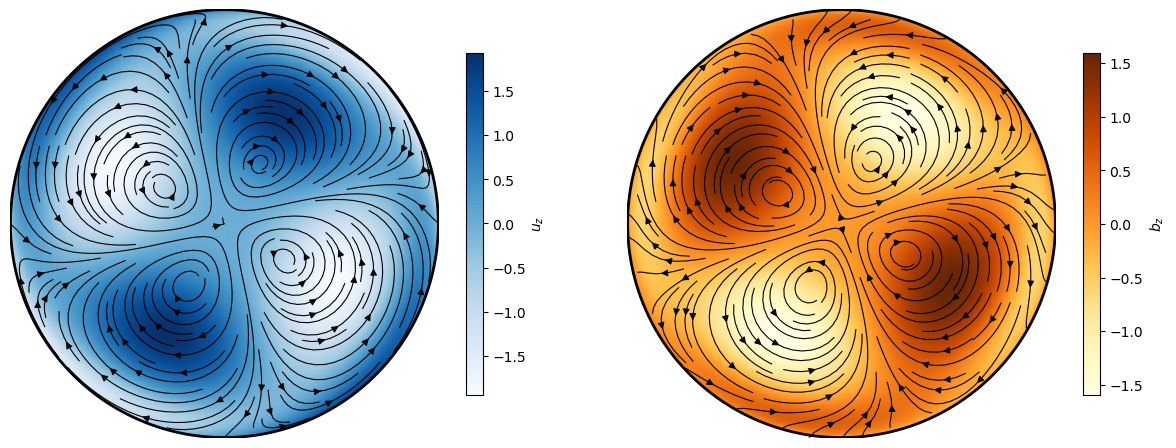

In [85]:
import numpy as np
import matplotlib.pyplot as plt

# === Extraction des champs scalaires ===
def extract_fields(u_total, s):
    n = len(s)
    return (u_total[:n], u_total[n:2*n], u_total[2*n:3*n], u_total[3*n:])

# === Génération des grilles ===
def make_grids(s, h, m, k, omega, t=0):
    n = len(s)
    phi = np.linspace(0, 2*np.pi, n)
    z = np.linspace(0, h, n)
    S, PHI, Z = np.meshgrid(s, phi, z, indexing='ij')
    return S, PHI, Z, np.exp(1j * (k*Z + m*PHI + omega*t)) * np.sin(k*Z)

# === Générique pour vitesse / champ magnétique ===
def compute_field_components(u_total, s, m, k, omega, D, h, t=0, kind='velocity'):
    T, P, G, F = extract_fields(u_total, s)
    F1, F2 = (T, P) if kind == 'velocity' else (G, F)
    D_F2 = D @ F2
    S, PHI, Z, phase = make_grids(s, h, m, k, omega, t)
    F1, F2, DF2 = [f[:, None, None] for f in (F1, F2, D_F2)]
    S2 = S**2

    comp_s   = (k**2 * F2 * S2 + m**2 * F2)
    comp_phi = (1j * k * F1 * S2 + 1j * m * S * DF2 - 1j * m * F2)
    comp_z   = (1j * k * DF2 * S2 + 1j * k * S * F2 - 1j * m * F1)
    return S, PHI, Z, (comp_s * phase).real, (comp_phi * phase).real, (comp_z * phase).real

# Raccourcis
def velocity(u, s, m, k, omega, D, h, t=0):
    return compute_field_components(u, s, m, k, omega, D, h, t, 'velocity')

def magnetic(u, s, m, k, omega, D, h, t=0):
    return compute_field_components(u, s, m, k, omega, D, h, t, 'magnetic')

# === Échelle automatique ===
def component_limits(u, s, m, k, omega, D, h, times, phi_idx=0, q=95):
    vals = {name: [] for name in ['v_s','v_phi','v_z','b_s','b_phi','b_z']}
    for t in times:
        _,_,_,vs,vphi,vz = velocity(u,s,m,k,omega,D,h,t)
        _,_,_,bs,bphi,bz = magnetic(u,s,m,k,omega,D,h,t)
        for key, arr in zip(vals.keys(), [vs,vphi,vz,bs,bphi,bz]):
            vals[key].append(np.abs(arr[:,phi_idx,:]))
    return {k: np.percentile(np.concatenate(v), q) for k,v in vals.items()}

# === PARAMÈTRES ===
omega0 = omega_dom
z0 = h*0.3

# === CHAMP DE VITESSE ===
S, PHI, Z, vs3d, vphi3d, vz3d = velocity(u_total, s, m, k, omega0, D, h, t=1)
z_idx = np.argmin(np.abs(Z[0,0,:] - z0))

vs_cut   = vs3d[:, :, z_idx]
vphi_cut = vphi3d[:, :, z_idx]
vz_cut   = vz3d[:, :, z_idx]

# === CHAMP MAGNETIQUE ===
_, _, _, bs3d, bphi3d, bz3d = magnetic(u_total, s, m, k, omega0, D, h, t=1)

bs_cut   = bs3d[:, :, z_idx]
bphi_cut = bphi3d[:, :, z_idx]
bz_cut   = bz3d[:, :, z_idx]

# === PASSAGE EN CARTÉSIEN ===
S2D, PHI2D = S[:,:,z_idx], PHI[:,:,z_idx]
X = S2D * np.cos(PHI2D)
Y = S2D * np.sin(PHI2D)

# composantes cartesiennes vitesse
ux = vs_cut * np.cos(PHI2D) - vphi_cut * np.sin(PHI2D)
uy = vs_cut * np.sin(PHI2D) + vphi_cut * np.cos(PHI2D)

# composantes cartesiennes magnétique
bx = bs_cut * np.cos(PHI2D) - bphi_cut * np.sin(PHI2D)
by = bs_cut * np.sin(PHI2D) + bphi_cut * np.cos(PHI2D)

# === GRILLE CARTÉSIENNE RÉGULIÈRE POUR STREAMPLOT ===
Ncart = 500
x_lin = np.linspace(-1, 1, Ncart)
y_lin = np.linspace(-1, 1, Ncart)
XC, YC = np.meshgrid(x_lin, y_lin)

# interpolation
points = np.vstack([X.ravel(), Y.ravel()]).T

uxC  = griddata(points, ux.ravel(),  (XC, YC), method='linear')
uyC  = griddata(points, uy.ravel(),  (XC, YC), method='linear')
uzC  = griddata(points, vz_cut.ravel(), (XC, YC), method='linear')

bxC  = griddata(points, bx.ravel(),  (XC, YC), method='linear')
byC  = griddata(points, by.ravel(),  (XC, YC), method='linear')
bzC  = griddata(points, bz_cut.ravel(), (XC, YC), method='linear')

# === FIGURE ===
fig, axes = plt.subplots(1, 2, figsize=(12,6))

# ---- VITESSE ----
ax = axes[0]
pc = ax.pcolormesh(XC, YC, uzC, shading='auto', cmap='Blues')
fig.colorbar(pc, ax=ax, label=r'$u_z$', shrink=0.6)
ax.streamplot(x_lin, y_lin, uxC, uyC, color='k', density=1.5, linewidth=0.8)

theta = np.linspace(0, 2*np.pi, 400)
ax.plot(np.cos(theta), np.sin(theta), 'k', lw=2)
ax.set_axis_off()
ax.set_aspect('equal')

# ---- CHAMP MAGNÉTIQUE ----
ax = axes[1]
pc = ax.pcolormesh(XC, YC, bzC, shading='auto', cmap='YlOrBr')
fig.colorbar(pc, ax=ax, label=r'$b_z$', shrink=0.6)
ax.streamplot(x_lin, y_lin, bxC, byC, color='k', density=1.5, linewidth=0.8)

ax.plot(np.cos(theta), np.sin(theta), 'k', lw=2)
ax.set_aspect('equal')

plt.tight_layout()
ax.set_axis_off()
#plt.savefig(f'/Users/alexandrenuyt/Documents/MHD - UCLouvain/Magneto-Coriolis Waves/MCWS/figures/(m,n)=({m},{n_axial})_(nu,eta)=({nu},{eta}).png', dpi=500, bbox_inches="tight")
plt.show()


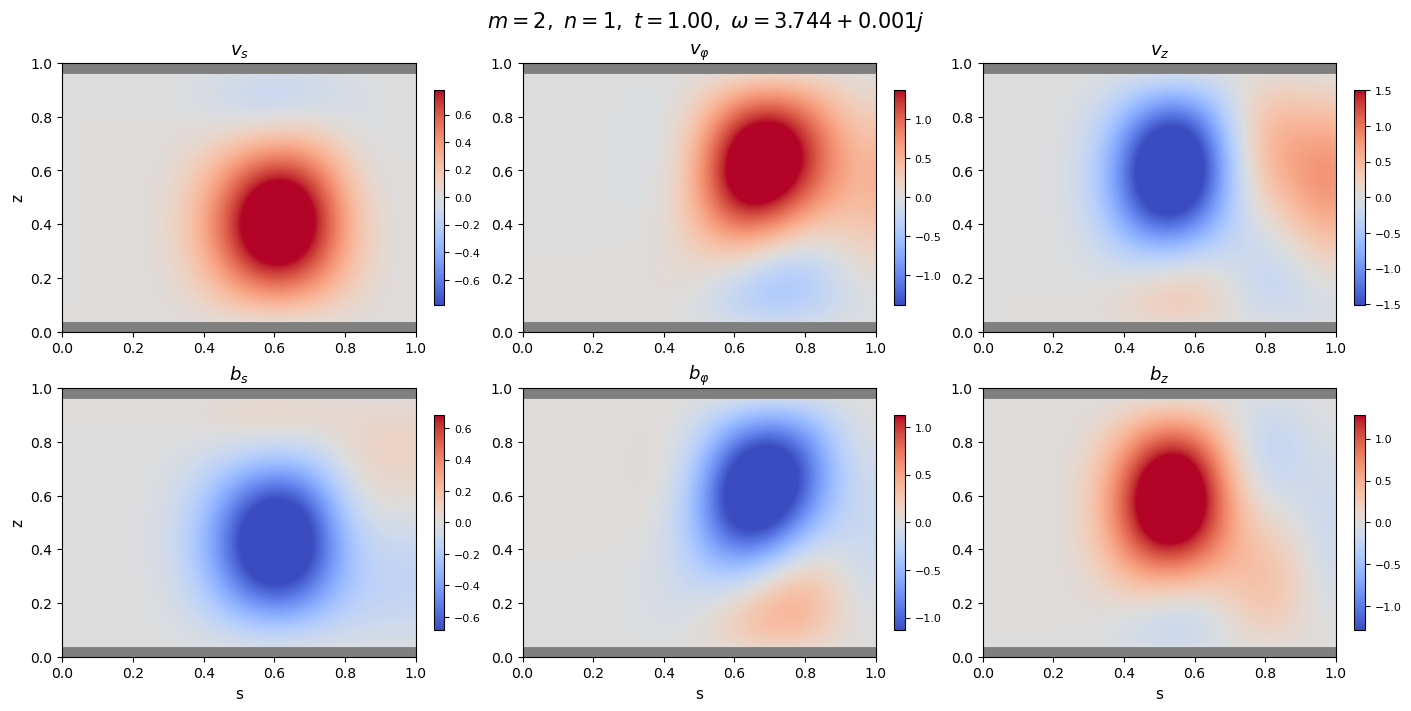

In [79]:
def plot_fields(u, s, m, k, omega, D, h, n_axial, times, phi_idx=0):
    # limites automatiques
    lims = component_limits(u, s, m, k, omega, D, h, times, phi_idx)
    smin, smax = s.min(), s.max()

    cmap = "coolwarm"   # lisibilité physique
    interpolation = "bilinear"  # rendu plus propre

    for t in times:
        # extraction des champs
        _,_,_,vs,vphi,vz = velocity(u, s, m, k, omega, D, h, t)
        _,_,_,bs,bphi,bz = magnetic(u, s, m, k, omega, D, h, t)

        fields = [[vs, vphi, vz],
                  [bs, bphi, bz]]

        labels = [["$v_s$", "$v_\\varphi$", "$v_z$"],
                  ["$b_s$", "$b_\\varphi$", "$b_z$"]]

        keys = [["v_s", "v_phi", "v_z"],
                ["b_s", "b_phi", "b_z"]]

        fig, ax = plt.subplots(2, 3, figsize=(14, 7), constrained_layout=True)

        for i in range(2):
            for j in range(3):

                # coupe axiale (s,z) pour φ=phi_idx
                data = fields[i][j][:, phi_idx, :]

                # imshow plus propre
                im = ax[i, j].imshow(
                    data.T,
                    origin="lower",
                    extent=[smin, smax, 0, h],
                    aspect="auto",
                    cmap=cmap,
                    interpolation=interpolation,
                    vmin=-lims[keys[i][j]],
                    vmax=lims[keys[i][j]],
                )

                ax[i, j].set_title(labels[i][j], fontsize=13)
                
                # paroi radiale
                #ax[i, j].axvline(1, color='#7f7f7f', ls="-", lw=1)

                # couvercles
                ax[i, j].axhline(0, color='#7f7f7f', lw=15)
                ax[i, j].axhline(h, color='#7f7f7f', lw=15)

                if i == 1:
                    ax[i, j].set_xlabel("s", fontsize=11)
                if j == 0:
                    ax[i, j].set_ylabel("z", fontsize=11)

                # colorbar clean
                cbar = fig.colorbar(im, ax=ax[i, j], shrink=0.8, pad=0.02)
                cbar.ax.tick_params(labelsize=8)

        plt.suptitle(
            rf"$m={m},\ n={n_axial},\ t={t:.2f},\ \omega={omega:.3f}$",
            fontsize=15,
            weight="bold",
        )
        plt.show()

# === Exemple d’utilisation ===
plot_fields(u_total, s, m, k, omega_dom, D, h, n_axial, np.linspace(1,1,1))


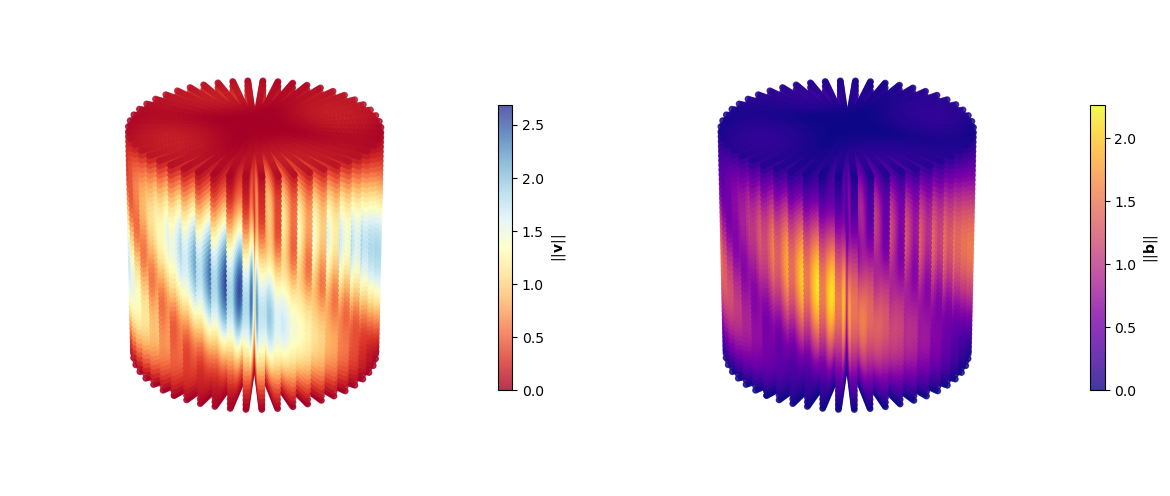

In [83]:
import numpy as np
import matplotlib.pyplot as plt

# ========= Paramètres ==========
t = 1.0
z0 = h * 0.2

# ========= Champs cylindriques ==========
S, PHI, Z, vs3d, vphi3d, vz3d = velocity(u_total, s, m, k, omega_dom, D, h, t)
_, _, _, bs3d, bphi3d, bz3d = magnetic(u_total, s, m, k, omega_dom, D, h, t)

# ========= Conversion cartésiens ==========
x = S * np.cos(PHI)
y = S * np.sin(PHI)
z = Z

V_x = vs3d*np.cos(PHI) - vphi3d*np.sin(PHI)
V_y = vs3d*np.sin(PHI) + vphi3d*np.cos(PHI)
V_z = vz3d

B_x = bs3d*np.cos(PHI) - bphi3d*np.sin(PHI)
B_y = bs3d*np.sin(PHI) + bphi3d*np.cos(PHI)
B_z = bz3d

V_norm = np.sqrt(V_x**2 + V_y**2 + V_z**2)
B_norm = np.sqrt(B_x**2 + B_y**2 + B_z**2)

# ========= Masque intérieur ==========
mask = ((S < 0.9) & (Z < 1))      # fenêtre interne
x_in  = x[mask]
y_in  = y[mask]
z_in  = z[mask]
Vn_in = V_norm[mask]
Bn_in = B_norm[mask]
"""
# ========= Downsampling pour un rendu propre ==========
#  pour éviter l'effet granuleux
Npts = 1000000
if len(x_in) > Npts:
    idx = np.random.choice(len(x_in), Npts, replace=False)
else:
    idx = slice(None)

x_in, y_in, z_in = x_in[idx], y_in[idx], z_in[idx]
Vn_in, Bn_in = Vn_in[idx], Bn_in[idx]
"""
# ========= FIGURE ==========
fig = plt.figure(figsize=(12,6))

# ---- VITESSE ----
ax1 = fig.add_subplot(121, projection='3d')
sc1 = ax1.scatter(x_in, y_in, z_in, c=Vn_in, cmap='RdYlBu', s=15, alpha=0.8)

ax1.set_axis_off()
ax1.set_facecolor("white")
ax1.view_init(elev=25, azim=40)
ax1.set_box_aspect([1,1,1])

cbar1 = fig.colorbar(sc1, ax=ax1, shrink=0.5, pad=0.02)
cbar1.set_label(r"$||\mathbf{v}||$")

# ---- MAGNÉTIQUE ----
ax2 = fig.add_subplot(122, projection='3d')
sc2 = ax2.scatter(x_in, y_in, z_in, c=Bn_in, cmap='plasma', s=15, alpha=0.8)

ax2.set_axis_off()
ax2.set_facecolor("white")
ax2.view_init(elev=25, azim=40)
ax2.set_box_aspect([1,1,1])

cbar2 = fig.colorbar(sc2, ax=ax2, shrink=0.5, pad=0.02)
cbar2.set_label(r"$||\mathbf{b}||$")

plt.tight_layout()
plt.show()


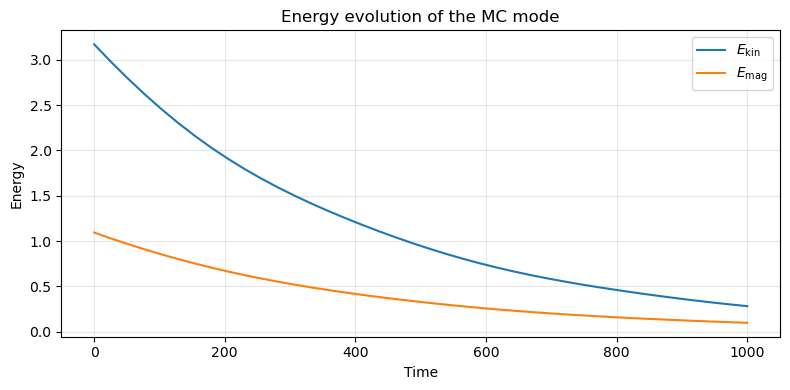

In [202]:
# === CONSTANTES PHYSIQUES ===
rho  = 1.0     # masse volumique (déjà dans ton code)
mu0  = 1.0     # perméabilité (déjà dans ton code)

# === CALCUL COMPLET DES ÉNERGIES ===

times = np.linspace(0, 1000, 40)
Ev_list = []
Eb_list = []
Etot_list = []

for t in times:

    # --- Vitesse ---
    _, _, _, vs, vphi, vz = velocity(u_total, s, m, k, omega_dom, D, h, t)
    # énergie cinétique (par unité de longueur, s déjà ton radial)
    Ek = 0.5 * rho * np.mean(vs**2 + vphi**2 + vz**2)

    # --- Champ magnétique ---
    _, _, _, bs, bphi, bz = magnetic(u_total, s, m, k, omega_dom, D, h, t)
    Em = 0.5 * (1/mu0) * np.mean(bs**2 + bphi**2 + bz**2)

    # --- Énergie totale ---
    Et = Ek + Em

    Ev_list.append(Ek)
    Eb_list.append(Em)
    Etot_list.append(Et)

Ev_list  = np.array(Ev_list)
Eb_list  = np.array(Eb_list)
Etot_list = np.array(Etot_list)

# === FIGURE ===
plt.figure(figsize=(8,4))
plt.plot(times, Ev_list,  label='$E_{\\rm kin}$')
plt.plot(times, Eb_list,  label='$E_{\\rm mag}$')
#plt.plot(times, Etot_list,label='$E_{\\rm tot}$', linewidth=2)
plt.xlabel("Time"); plt.ylabel("Energy")
plt.title("Energy evolution of the MC mode")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()
